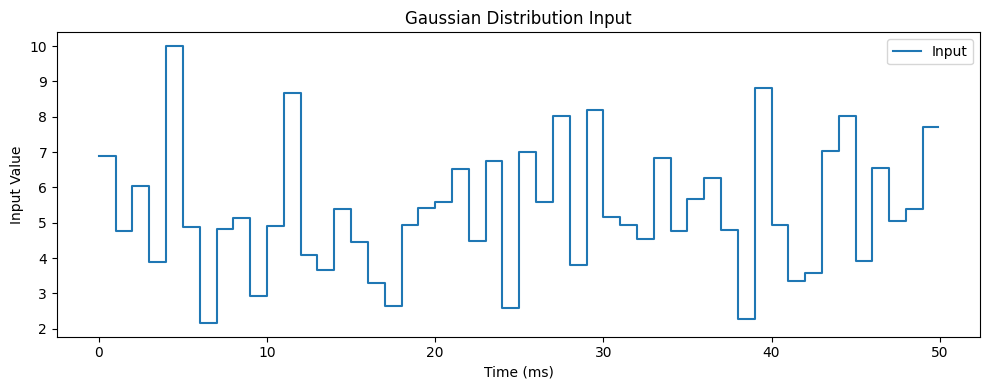

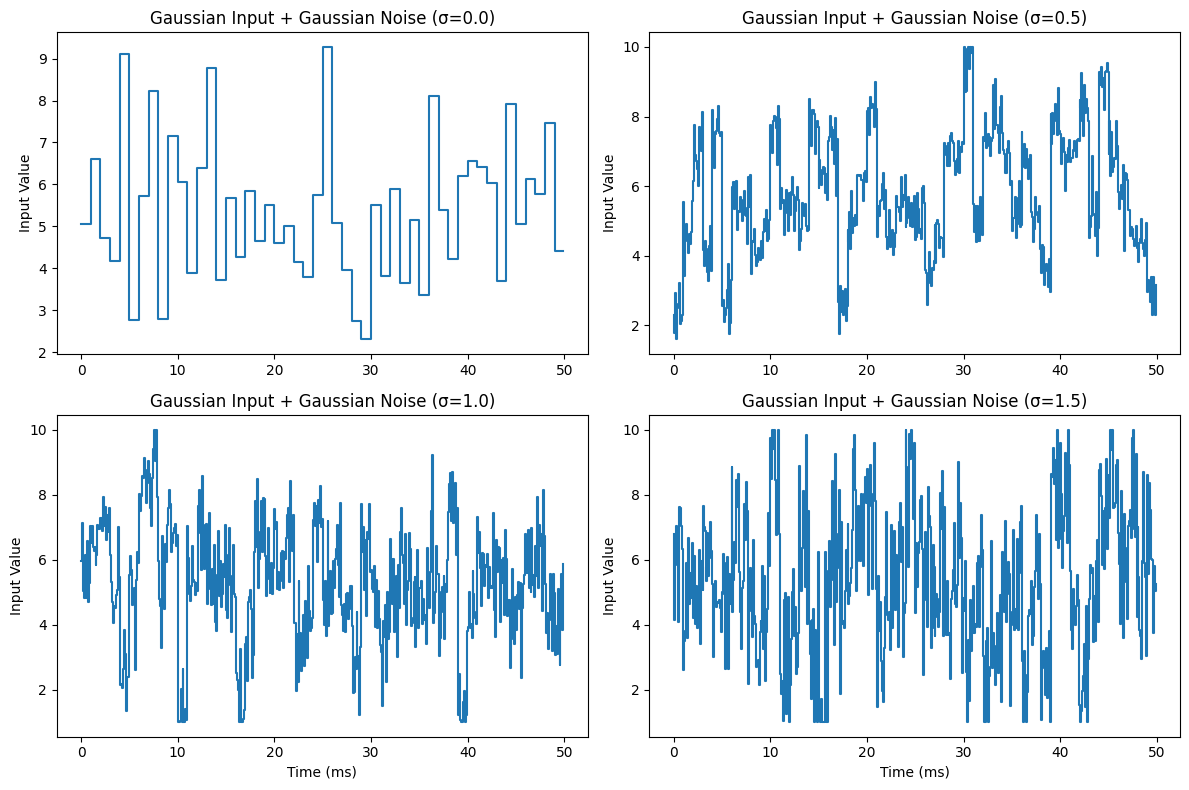

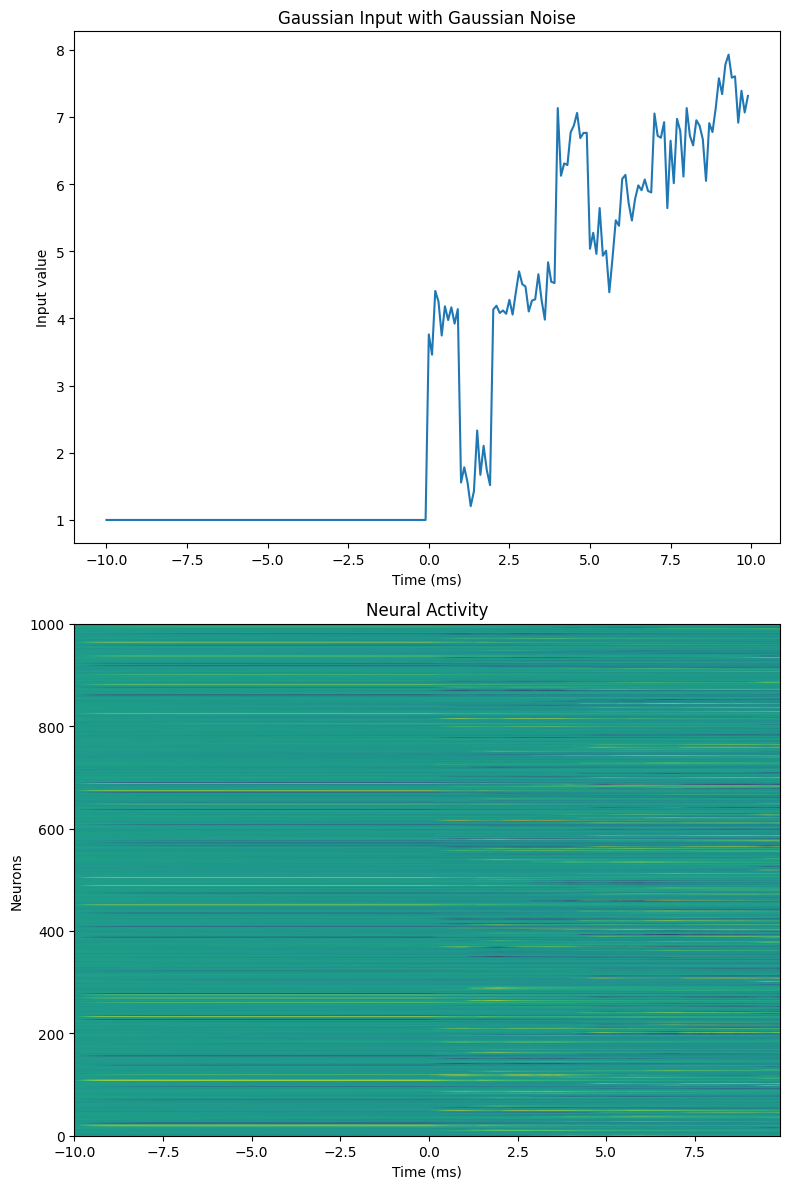

c:\Users\lotus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


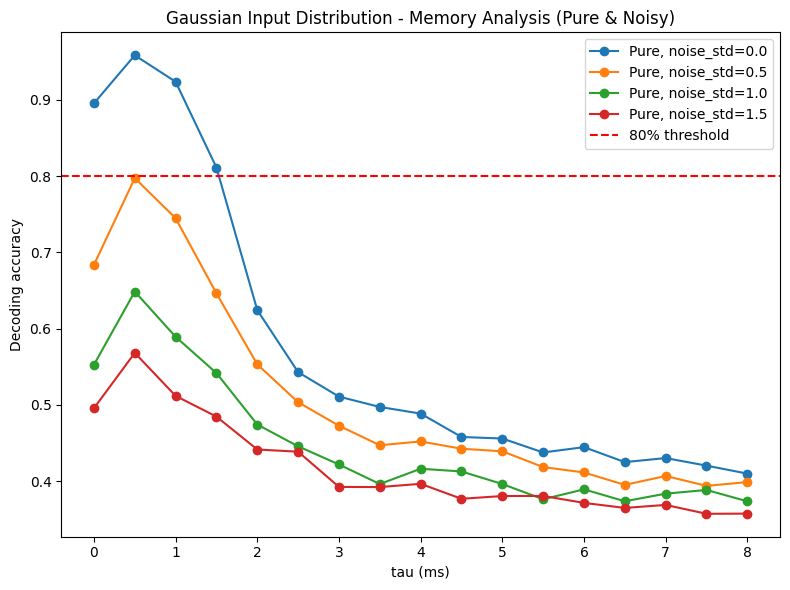

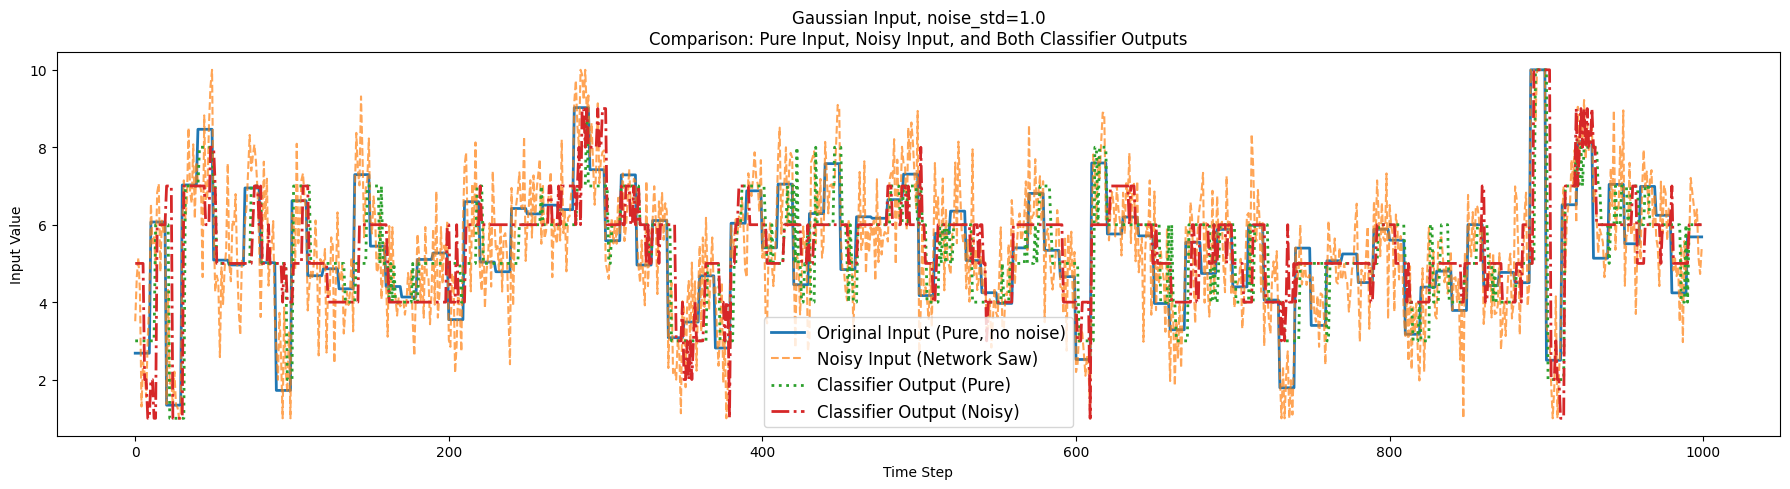

Accuracy (recovering pure/original input): 0.633
Accuracy (recovering noisy input): 0.387


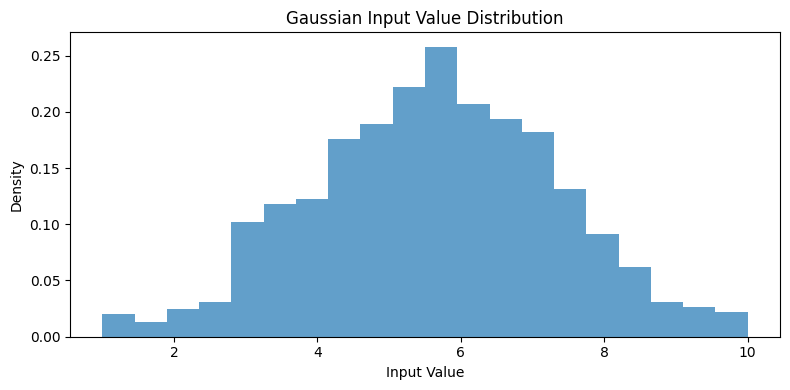

In [2]:
# ==== Model setup ====
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

seed = 42
np.random.seed(seed)

model = {}
model['N'] = 1000  # For speed during prototyping, set to 200; for final runs, use 1000+
model['g'] = 0.95
model['sp'] = 0.35
model['tau'] = 20
model['dt'] = 0.1
model['nonlin'] = lambda x: np.tanh(x)

model['nIn'] = 10
model['gIn'] = 10.0
model['spIn'] = 0.05
model['burnIn'] = 10
model['durIn'] = 1
model['ISI'] = 0
model['nonlinIn'] = lambda x: x

# ==== Sparse version for speed (recommended for large N) ====
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = (np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp'])
model['J'] = csr_matrix(randMat * spMat * model['g'] / math.sqrt(model['N'] * model['sp']))
#model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])  # dense fallback

randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = (np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn'])
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

def step(firing_rates, input_layer, model):
    alpha = math.exp(-model['dt']/model['tau'])
    # Sparse×dense for speed
    vIn = model['J'].dot(firing_rates) + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
    updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * alpha)
    return updated_rates

# ==== Quantization helper with optional rounding mode ====
def quantize_labels(y, nIn, method='round'):
    if method == 'floor':
        q = np.floor(y)
    elif method == 'ceil':
        q = np.ceil(y)
    else:
        q = np.round(y)
    return np.clip(q, 1, nIn).astype(int) - 1

# ==== Gaussian input and noise distributions ====
def make_input_gaussian(sequence_length, model, noise_std=0.0, return_pure=False):
    # Localize constants so they follow model['nIn']
    mean_val = (model['nIn'] + 1) / 2
    std_val  = model['nIn'] / 6
    n_burn = int(model['burnIn'] / model['dt'])
    input_stream = [0.0] * n_burn
    pure_stream  = []

    for _ in range(sequence_length):
        val = np.random.normal(mean_val, std_val)
        val = np.clip(val, 1, model['nIn'])
        pure_stream.append(val)
        for t in range(int(model['ISI']/model['dt'])):
            input_stream.append(0.0)
        for t in range(int(model['durIn']/model['dt'])):
            input_stream.append(val)

    pure_expanded = [0.0]*n_burn
    for val in pure_stream:
        for t in range(int(model['ISI']/model['dt'])):
            pure_expanded.append(0.0)
        for t in range(int(model['durIn']/model['dt'])):
            pure_expanded.append(val)

    input_arr = np.array(input_stream, dtype=float)
    pure_arr  = np.array(pure_expanded, dtype=float)

    noisy = input_arr.copy()
    if noise_std > 0:
        mask = noisy > 0
        noise = np.random.normal(0, noise_std, size=mask.sum())
        noisy[mask] += noise
        # For fully class-based, never-zero input, clip to [1, nIn]
        noisy = np.clip(noisy, 1, model['nIn'])

    discrete = np.round(noisy).astype(int)
    discrete = np.clip(discrete, 1, model['nIn'])
    onehot = np.zeros((model['nIn'], len(discrete)))
    idx = np.where(discrete > 0)[0]
    onehot[discrete[idx]-1, idx] = 1.0

    if return_pure:
        return onehot, noisy, pure_arr
    else:
        return onehot, noisy

# ==== Plotting Helper ====
def plot_timeseries(x, ys, labels, title='', ylabel='', xlabel='', styles=None):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, y in enumerate(ys):
        style = {} if styles is None else styles[i]
        ax.step(x, y, where='post', label=labels[i], **style)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ==== Visualization of Gaussian input distribution ====
onehot, stream = make_input_gaussian(50, model, noise_std=0.0)
omit = int(model['burnIn']/model['dt'])
time = np.arange(len(stream) - omit) * model['dt']
plot_timeseries(time, [stream[omit:]], ['Input'],
                title='Gaussian Distribution Input',
                ylabel='Input Value', xlabel='Time (ms)')

# ==== Comparison of Gaussian noise levels ====
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
noise_levels = [0.0, 0.5, 1.0, 1.5]
for i, noise_std in enumerate(noise_levels):
    row, col = i // 2, i % 2
    onehot, stream = make_input_gaussian(50, model, noise_std=noise_std)
    omit = int(model['burnIn']/model['dt'])
    time = np.arange(len(stream) - omit) * model['dt']
    axes[row, col].step(time, stream[omit:], where='post')
    axes[row, col].set_title(f'Gaussian Input + Gaussian Noise (σ={noise_std})')
    axes[row, col].set_ylabel('Input Value')
    if row == 1:
        axes[row, col].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# ==== Run simulation with Gaussian input and noise ====
onehot, input_stream, pure_stream = make_input_gaussian(10, model, noise_std=0.3, return_pure=True)
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))
for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)

simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')
ax[0].set_title('Gaussian Input with Gaussian Noise')
extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
ax[1].set_title('Neural Activity')
plt.tight_layout()
plt.show()

# ==== Memory analysis with Gaussian input distribution ====
SEQ_LEN = 1000
threshold = 0.80
noise_levels = [0.0, 0.5, 1.0, 1.5]

plt.figure(figsize=(8, 6))
for noise_std in noise_levels:
    onehot, input_stream, pure_stream = make_input_gaussian(SEQ_LEN, model, noise_std=noise_std, return_pure=True)
    firing_rates = np.zeros((model['N'], len(input_stream)))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))
    for t in range(len(input_stream)-1):
        firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)
    omit = int(model['burnIn'] / model['dt'])
    X_all = firing_rates[:, omit:].T
    y_p_int = quantize_labels(pure_stream[omit:], model['nIn'])
    y_n_int = quantize_labels(input_stream[omit:], model['nIn'])
    T = X_all.shape[0]
    dt = model['dt']
    max_tau_ms = 7.5
    taus = np.arange(0, max_tau_ms + 1, 0.5)
    accuracies_pure = []
    accuracies_noisy = []
    for tau in taus:
        lag = int(tau / dt)
        if T - lag <= 0:
            break
        X = X_all[lag:]
        y_p = y_p_int[:-lag] if lag > 0 else y_p_int
        y_n = y_n_int[:-lag] if lag > 0 else y_n_int
        X_train, X_test, y_train_pure_int, y_test_pure_int, y_train_noisy_int, y_test_noisy_int = \
            train_test_split(
                X, y_p, y_n,
                test_size=0.3,
                random_state=42
            )
        if len(np.unique(y_train_pure_int)) < 2 or len(np.unique(y_test_pure_int)) < 2:
            accuracies_pure.append(np.nan)
        else:
            clf_pure = LogisticRegression(max_iter=1000, solver='lbfgs', C=5)
            clf_pure.fit(X_train, y_train_pure_int)
            y_pred_pure = clf_pure.predict(X_test)
            acc_pure = accuracy_score(y_test_pure_int, y_pred_pure)
            accuracies_pure.append(acc_pure)
        if len(np.unique(y_train_noisy_int)) < 2 or len(np.unique(y_test_noisy_int)) < 2:
            accuracies_noisy.append(np.nan)
        else:
            clf_noisy = LogisticRegression(max_iter=1000, solver='lbfgs', C=5)
            clf_noisy.fit(X_train, y_train_noisy_int)
            y_pred_noisy = clf_noisy.predict(X_test)
            acc_noisy = accuracy_score(y_test_noisy_int, y_pred_noisy)
            accuracies_noisy.append(acc_noisy)
    accuracies_pure = np.array(accuracies_pure)
    accuracies_noisy = np.array(accuracies_noisy)
    plt.plot(taus[:len(accuracies_pure)], accuracies_pure, marker='o', label=f"Pure, noise_std={noise_std}")
    #plt.plot(taus[:len(accuracies_noisy)], accuracies_noisy, marker='x', linestyle='--', label=f"Noisy, noise_std={noise_std}")

plt.axhline(threshold, color='r', linestyle='--', label=f'{int(threshold*100)}% threshold')
plt.xlabel('tau (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Gaussian Input Distribution - Memory Analysis (Pure & Noisy)')
plt.legend()
plt.tight_layout()
plt.show()

# ==== Comparison plot for a single simulation ====
SEQ_LEN = 100
noise_std = 1.0
onehot, input_stream, pure_stream = make_input_gaussian(SEQ_LEN, model, noise_std=noise_std, return_pure=True)
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))
for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)
omit = int(model['burnIn'] / model['dt'])
Xf = firing_rates[:, omit:].T
pure_f = pure_stream[omit:]
inp_f  = input_stream[omit:]
yp = quantize_labels(pure_f, model['nIn'])
yn = quantize_labels(inp_f,  model['nIn'])
# For fair accuracy, use train/test split (uncomment if desired)
# X_train, X_test, y_train, y_test = train_test_split(Xf, yp, test_size=0.3, random_state=42)
# clf_pure = LogisticRegression(max_iter=1000, solver='lbfgs')
# clf_pure.fit(X_train, y_train)
# y_pred = clf_pure.predict(X_test)
# print("Single-trial accuracy (pure, holdout test):", accuracy_score(y_test, y_pred))
# Otherwise, fit on all data for illustration:
clf_pure = LogisticRegression(max_iter=1000, solver='lbfgs')
clf_pure.fit(Xf, yp)
clf_noisy = LogisticRegression(max_iter=1000, solver='lbfgs')
clf_noisy.fit(Xf, yn)
y_pred_pure = clf_pure.predict(Xf)
y_pred_noisy = clf_noisy.predict(Xf)

plt.figure(figsize=(18,5))
plt.plot(pure_f, label='Original Input (Pure, no noise)', linewidth=2)
plt.plot(inp_f, label='Noisy Input (Network Saw)', linestyle='--', alpha=0.7)
plt.plot(y_pred_pure + 1, label='Classifier Output (Pure)', linestyle=':', linewidth=2)
plt.plot(y_pred_noisy + 1, label='Classifier Output (Noisy)', linestyle='-.', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Input Value')
plt.legend(fontsize=12)
plt.title(f'Gaussian Input, noise_std={noise_std}\nComparison: Pure Input, Noisy Input, and Both Classifier Outputs')
plt.tight_layout()
plt.show()

print('Accuracy (recovering pure/original input):', accuracy_score(yp, y_pred_pure))
print('Accuracy (recovering noisy input):', accuracy_score(yn, y_pred_noisy))

# ==== Visualize Gaussian input distribution ====
mean_val = (model['nIn'] + 1) / 2
std_val  = model['nIn'] / 6
samples = np.clip(np.random.normal(mean_val, std_val, size=1000), 1, model['nIn'])
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(samples, bins=20, alpha=0.7, density=True)
ax.set_title('Gaussian Input Value Distribution')
ax.set_xlabel('Input Value')
ax.set_ylabel('Density')
plt.tight_layout()
plt.show()
